In [32]:
from hmmlearn import hmm
import mne_bids
from matplotlib import pyplot as plt
import numpy as np 
import json

### read examplary data from Berlin data

In [7]:
run_file_to_read = r'C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS_Berlin\sub-002\ses-20200131\ieeg\sub-002_ses-20200131_task-SelfpacedRotationR_acq-MedOn+StimOff_run-4_ieeg.vhdr'
entities = mne_bids.get_entities_from_fname(run_file_to_read)
bids_path = mne_bids.BIDSPath(subject=entities["subject"], session=entities["session"], task=entities["task"], \
    run=entities["run"], acquisition=entities["acquisition"], datatype="ieeg", root="C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\Datasets\\BIDS_Berlin")
raw_arr = mne_bids.read_raw_bids(bids_path)

Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS_Berlin\sub-002\ses-20200131\ieeg\sub-002_ses-20200131_task-SelfpacedRotationR_acq-MedOn+StimOff_run-4_ieeg.vhdr...
Setting channel info structure...
Reading events from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS_Berlin\sub-002\ses-20200131\ieeg\sub-002_ses-20200131_task-SelfpacedRotationR_acq-MedOn+StimOff_run-4_events.tsv.
Reading channel info from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BIDS_Berlin\sub-002\ses-20200131\ieeg\sub-002_ses-20200131_task-SelfpacedRotationR_acq-MedOn+StimOff_run-4_channels.tsv.
Reading in coordinate system frame other: None.
Reading electrode coords from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\Datasets\BID

<ipython-input-7-c27250336c19>:5: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['ANALOG_ROT_R_1']
  raw_arr = mne_bids.read_raw_bids(bids_path)
<ipython-input-7-c27250336c19>:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_arr = mne_bids.read_raw_bids(bids_path)


In [9]:
raw_arr.get_data().shape

(12, 613328)

In [10]:
raw_arr.ch_names

['LFP_STN_R_234',
 'LFP_STN_R_567',
 'LFP_BS_STN_L_1',
 'LFP_STN_L_234',
 'LFP_STN_L_567',
 'ECOG_AT_SM_L_1',
 'ECOG_AT_SM_L_2',
 'ECOG_AT_SM_L_3',
 'ECOG_AT_SM_L_4',
 'ECOG_AT_SM_L_5',
 'ECOG_AT_SM_L_6',
 'ANALOG_ROT_R_1']

In [21]:
X = raw_arr.get_data()[:-1,100000:][:,::10]
y = raw_arr.get_data()[-1,100000:][::10]

In [22]:
X.shape

(11, 51333)

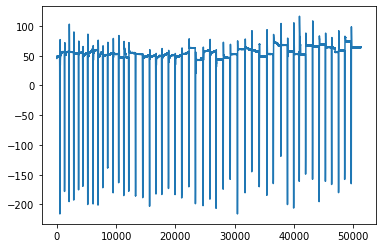

In [23]:
plt.plot(y)

In [4]:
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100)

In [15]:
remodel.monitor_

ConvergenceMonitor(
    history=[],
    iter=0,
    n_iter=100,
    tol=0.01,
    verbose=False,
)

### read feature dat

In [26]:
file = r'C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\ECoG_STN\combined_dat\dat\sub_000_patient_concat.json'

In [27]:
import json

with open(file) as json_file:
    data = json.load(json_file)

In [38]:
X = np.array(data["ECOG_RIGHT_0"]["data"])
y = np.array(data["ECOG_RIGHT_0"]["true_movements"])

In [78]:
hmm.GaussianHMM?

In [84]:
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)

In [85]:
remodel.fit(X=X.T)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=2, n_iter=100, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [86]:
remodel.get_params()

{'algorithm': 'viterbi',
 'covariance_type': 'full',
 'covars_prior': 0.01,
 'covars_weight': 1,
 'init_params': 'stmc',
 'means_prior': 0,
 'means_weight': 0,
 'min_covar': 0.001,
 'n_components': 2,
 'n_iter': 100,
 'params': 'stmc',
 'random_state': None,
 'startprob_prior': 1.0,
 'tol': 0.01,
 'transmat_prior': 1.0,
 'verbose': False}

In [87]:
remodel.monitor_

ConvergenceMonitor(
    history=[6855.67752479209, 6855.685592614144],
    iter=20,
    n_iter=100,
    tol=0.01,
    verbose=False,
)

In [99]:
from sklearn import metrics

In [100]:
metrics.r2_score(y.sum(axis=0), remodel.predict(X.T))

0.16914161193704358

Text(0.5, 1.0, 'sum con-ips movement $r^2$=0.17')

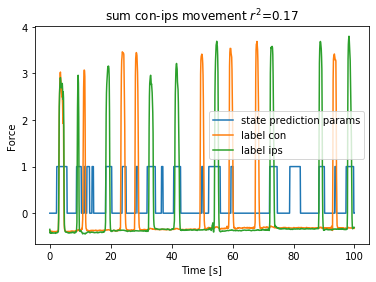

In [104]:
x_ = np.arange(0, 1000, 1)*0.1
plt.plot(x_, remodel.predict(X.T)[:1000], label="state prediction params")
plt.plot(x_, y[0,:1000], label="label con")
plt.plot(x_, y[1,:1000], label="label ips")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Force")
plt.title("sum con-ips movement "+r"$r^2$"+"="+str(np.round(metrics.r2_score(y.sum(axis=0), remodel.predict(X.T)),2)))

In [75]:
remodel.decode(X.T)

(27298.379134229017, array([0, 0, 0, ..., 5, 5, 5]))

In [58]:
remodel.decode?

In [63]:
arr_sampled = remodel.sample(1000)

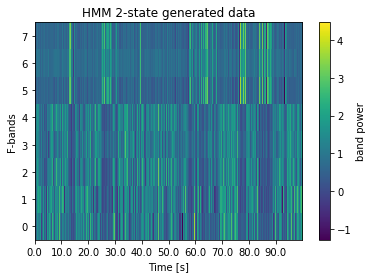

In [98]:
plt.imshow(arr_sampled[0].T, aspect='auto')
plt.gca().invert_yaxis()
x_ = np.arange(0, 1000, 1)*0.1
plt.xticks(np.arange(0, 1000, 100), x_[::100])
plt.xlabel("Time [s]")
plt.ylabel("F-bands")
cbar = plt.colorbar()
cbar.set_label("band power")
plt.title("HMM 2-state generated data")
plt.show()

In [68]:
remodel.fit?

In [112]:
remodel.transmat_

array([[0.97198596, 0.02801404],
       [0.0631055 , 0.9368945 ]])

(-0.5, 1.5)

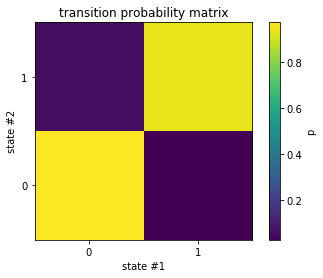

In [111]:
plt.imshow(remodel.transmat_)
cbar = plt.colorbar()
cbar.set_label("p")
plt.title("transition probability matrix")
plt.xticks([0,1],[0,1])
plt.yticks([0,1],[0,1])
plt.xlabel("state #1")
plt.ylabel("state #2")
plt.ylim(-0.5, 1.5)